### create a function to crop images using their bboxes, and save the crops as separate images, which will be used for classification

Crops are saved in the ImageFolder format:<br>
dataset/

dataset/train

dataset/eval

dataset/train/class.1-class.2-...

dataset/eval/class.1-class.2-...

dataset/train/class.1/imagename-0.jpg

dataset/train/class.1/imagename-1.jpg

dataset/train/class.2/imagename-0.jpg

dataset/train/class.2/imagename-1.jpg

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os 
import cv2

In [89]:
root = '../my_custom_dataset/'

In [67]:
df = pd.read_csv('../my_custom_dataset/annotations.csv', header=None)

In [68]:
df.head()

,0,1,2,3,4,5,6
0,'TRAINING','images/000000425226.jpg','person',0.152083,0.321875,0.777083,0.903125
1,'TRAINING','images/000000440475.jpg','person',0.767188,0.428571,0.820312,0.599532
2,'TRAINING','images/000000266400.jpg','person',0.056250,0.000000,0.115625,0.133838
3,'TRAINING','images/000000069213.jpg','person',0.431250,0.021077,0.812500,0.957845
4,'TRAINING','images/000000555050.jpg','person',0.194000,0.574534,0.250000,0.658385


In [69]:
df.shape

(11759, 7)

In [70]:
dfsorted = df.sort_values(1, axis=0)

In [71]:
dfsorted.head()

,0,1,2,3,4,5,6
7971,'TEST','images/000000000139.jpg','person',0.600000,0.403756,0.623437,0.485915
7967,'TEST','images/000000000139.jpg','person',0.643750,0.368545,0.726562,0.692488
5368,'TRAINING','images/000000000785.jpg','person',0.437500,0.103529,0.778125,0.917647
9580,'VALIDATION','images/000000000872.jpg','person',0.233494,0.156250,0.702093,0.870313
9584,'VALIDATION','images/000000000872.jpg','person',0.262480,0.196875,0.689211,0.946875


### add the imgid to the dataframe

In [73]:
imgids = []
for i in range(0,dfsorted.shape[0]):
    imgids.append(dfsorted.iloc[i,1].replace("'","").replace(' ','').replace('images/','').replace('.jpg',''))

In [74]:
dfsorted['imgid'] = imgids

In [75]:
dfsorted.head()

,0,1,2,3,4,5,6,imgid
7971,'TEST','images/000000000139.jpg','person',0.600000,0.403756,0.623437,0.485915,000000000139
7967,'TEST','images/000000000139.jpg','person',0.643750,0.368545,0.726562,0.692488,000000000139
5368,'TRAINING','images/000000000785.jpg','person',0.437500,0.103529,0.778125,0.917647,000000000785
9580,'VALIDATION','images/000000000872.jpg','person',0.233494,0.156250,0.702093,0.870313,000000000872
9584,'VALIDATION','images/000000000872.jpg','person',0.262480,0.196875,0.689211,0.946875,000000000872


### add the postfix to the dataframe

In [76]:
idx = 0
postfix = 0
postfixlist = []
for id in imgids:
    if id != idx:
        idx = id
        postfix = 0
        postfixlist.append(postfix)
    else:
        postfix += 1
        postfixlist.append(postfix)

In [77]:
dfsorted['postfix'] = postfixlist

In [78]:
dfsorted.head()

,0,1,2,3,4,5,6,imgid,postfix
7971,'TEST','images/000000000139.jpg','person',0.600000,0.403756,0.623437,0.485915,000000000139,0
7967,'TEST','images/000000000139.jpg','person',0.643750,0.368545,0.726562,0.692488,000000000139,1
5368,'TRAINING','images/000000000785.jpg','person',0.437500,0.103529,0.778125,0.917647,000000000785,0
9580,'VALIDATION','images/000000000872.jpg','person',0.233494,0.156250,0.702093,0.870313,000000000872,0
9584,'VALIDATION','images/000000000872.jpg','person',0.262480,0.196875,0.689211,0.946875,000000000872,1


### make the target filename but concatenating the imgid and postfix columns 

In [83]:
targetnamelist = []
for i in range(0, dfsorted.shape[0]):
    imgid = dfsorted.iloc[i]['imgid']
    postfix = dfsorted.iloc[i]['postfix']
    targetname = f'{imgid}-{postfix}.jpg'
    targetnamelist.append(targetname)

In [84]:
dfsorted['targetname'] = targetnamelist

In [85]:
dfsorted.head(20)

,0,1,2,3,4,5,6,imgid,postfix,targetname
7971,'TEST','images/000000000139.jpg','person',0.600000,0.403756,0.623437,0.485915,000000000139,0,000000000139-0.jpg
7967,'TEST','images/000000000139.jpg','person',0.643750,0.368545,0.726562,0.692488,000000000139,1,000000000139-1.jpg
5368,'TRAINING','images/000000000785.jpg','person',0.437500,0.103529,0.778125,0.917647,000000000785,0,000000000785-0.jpg
9580,'VALIDATION','images/000000000872.jpg','person',0.233494,0.156250,0.702093,0.870313,000000000872,0,000000000872-0.jpg
9584,'VALIDATION','images/000000000872.jpg','person',0.262480,0.196875,0.689211,0.946875,000000000872,1,000000000872-1.jpg
8384,'TEST','images/000000000885.jpg','person',0.448437,0.000000,0.517188,0.025761,000000000885,0,000000000885-0.jpg
8057,'TEST','images/000000000885.jpg','person',0.432812,0.442623,0.651563,0.929742,000000000885,1,000000000885-1.jpg
8335,'TEST','images/000000000885.jpg','person',0.439063,0.208431,0.612500,0.604215,000000000885,2,000000000885-2.jpg
8375,'TEST','images/000000000885.jpg','person',0.929688,0.058548,0.996875,0.590164,000000000885,3,000000000885-3.jpg
9074,'TEST','images/000000000885.jpg','person',0.001563,0.000000,0.092187,0.018735,000000000885,4,000000000885-4.jpg


### make the directories

In [43]:
classes = dfsorted[2].unique()
classes = [c.replace(' ','').replace("'","") for c in classes]
classes

['person', 'animal']

In [44]:
rootdirs = ['train','test','val']

for rootdir in rootdirs:
    for classi in classes:
        os.makedirs(f'{rootdir}/{classi}')

### get the crop of the image from each bbox

In [ ]:
i = 2

In [110]:
filepath = dfsorted.iloc[i, 1].replace("'","").replace(' ', '')
filepath

'images/000000000785.jpg'

In [111]:
label = dfsorted.iloc[i, 2]

In [122]:
relpath = os.path.join(root, filepath)
img = cv2.imread(relpath)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

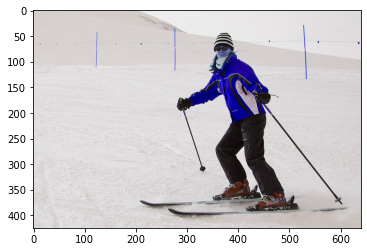

In [129]:
plt.imshow(img) # image is in BGR

In [124]:
img.shape

(425, 640, 3)

In [125]:
xmin = int(dfsorted.iloc[i, 3] * img.shape[1])
ymin = int(dfsorted.iloc[i, 4] * img.shape[0])
xmax = int(dfsorted.iloc[i, 5] * img.shape[1])
ymax = int(dfsorted.iloc[i, 6] * img.shape[0])

In [126]:
xmin, ymin, xmax, ymax

(280, 43, 498, 390)

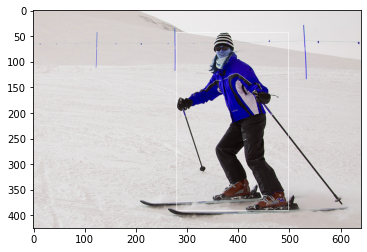

In [128]:
imgcopy = img.copy()
cv2.rectangle(imgcopy, (xmin, ymin), (xmax, ymax), (255,255,255), 1)
plt.imshow(imgcopy)

the bboxes are found correctly

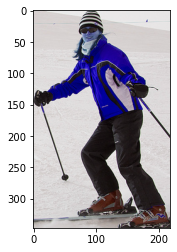

In [134]:
imgcropped = img[ymin:ymax, xmin:xmax]
plt.imshow(imgcropped)

image cropped successfully

### save the crop 

In [136]:
dfsorted.iloc[i, 0]

"'TRAINING'"

In [139]:
imagetype = dfsorted.iloc[i, 0].replace("'","").replace(' ','')
if imagetype == 'TRAINING':
    folder = 'train'    
elif imagetype == 'TEST':
    folder = 'test'
elif imagetype == 'VALIDATION':
    folder = 'val'
targetfilename = dfsorted.iloc[i]['targetname'], imgcropped 
label = dfsorted.iloc[i, 2].replace("'","").replace(' ','')
fullpath = f'{folder}/{label}/{targetname}'
print(fullpath)
cv2.imwrite(fullpath, imgcropped)

train/person/000000581357-10.jpg


True

image was saved successfully. put everything in a function and loop through the images

### create a function 

In [46]:
def crop_and_save(root='../my_custom_dataset/', # this is where the image and annotations folder is located
                 annotcsvfileloc='../my_custom_dataset/annotations.csv', # this is where the annotations csv is located                 
                 maxindex=None):
    df = pd.read_csv(annotcsvfileloc, header=None)
    dfsorted = df.sort_values(1, axis=0)
    # get the target filename to the df
    imgids = []
    for i in range(0,dfsorted.shape[0]):
        imgids.append(dfsorted.iloc[i,1].replace("'","").replace(' ','').replace('images/','').replace('.jpg',''))
    dfsorted['imgid'] = imgids
    
    idx = 0
    postfix = 0
    postfixlist = []
    for id in imgids:
        if id != idx:
            idx = id
            postfix = 0
            postfixlist.append(postfix)
        else:
            postfix += 1
            postfixlist.append(postfix)
    dfsorted['postfix'] = postfixlist
    
    targetnamelist = []
    for i in range(0, dfsorted.shape[0]):
        imgid = dfsorted.iloc[i]['imgid']
        postfix = dfsorted.iloc[i]['postfix']
        targetname = f'{imgid}-{postfix}.jpg'
        targetnamelist.append(targetname)
    dfsorted['targetname'] = targetnamelist
    
    # make the directories
    classes = dfsorted[2].unique()
    classes = [c.replace(' ','').replace("'","") for c in classes]
    
    rootdirs = ['train','test','val']
    for rootdir in rootdirs:
        for classi in classes:
            os.makedirs(f'{rootdir}/{classi}')
               
    # crop the image
    if maxindex is not None:
        limit = maxindex
    else:
        limit = dfsorted.shape[0]
    for i in range(0,limit):
        filepath = dfsorted.iloc[i, 1].replace("'","").replace(' ', '')
        label = dfsorted.iloc[i, 2]
        relpath = os.path.join(root, filepath)
        img = cv2.imread(relpath)

        xmin = int(dfsorted.iloc[i, 3] * img.shape[1])
        ymin = int(dfsorted.iloc[i, 4] * img.shape[0])
        xmax = int(dfsorted.iloc[i, 5] * img.shape[1])
        ymax = int(dfsorted.iloc[i, 6] * img.shape[0])

        imgcropped = img[ymin:ymax, xmin:xmax]

        # save the cropped image
        imagetype = dfsorted.iloc[i, 0].replace("'","").replace(' ','')
        if imagetype == 'TRAINING':
            folder = 'train'    
        elif imagetype == 'TEST':
            folder = 'test'
        elif imagetype == 'VALIDATION':
            folder = 'val'
        targetfilename = dfsorted.iloc[i]['targetname']
        label = dfsorted.iloc[i, 2].replace("'","").replace(' ','')
        fullpath = f'{folder}/{label}/{targetfilename}'
        if imgcropped.shape[0] > 0 and imgcropped.shape[1] > 0: # sometimes the crops are so small that they're empty after converting to int. check coco image 143068. check the appendix for error message 
            cv2.imwrite(fullpath, imgcropped)

In [47]:
crop_and_save(maxindex=20)

### Conclusion 

function works as expected. if the crops have width or length = 0 (after conversion from absolute to pixel values to int), then these crops are discarded. <br>
maxindex -> till which index in the dataframe should we run the crop (essentially, how many bboxes should be cropped and saved)<br>
if a maxindex is not specified, it'll run the crop for all the images

### appendix 

train/person/000000142472-5.jpg
train/person/000000142585-0.jpg
train/person/000000142585-1.jpg
val/person/000000142620-0.jpg
train/person/000000142790-0.jpg
train/person/000000142790-1.jpg
train/person/000000142971-0.jpg
test/person/000000142971-1.jpg
train/person/000000142971-2.jpg
train/person/000000142971-3.jpg
val/person/000000143068-0.jpg
val/person/000000143068-1.jpg
val/person/000000143068-2.jpg
val/person/000000143068-3.jpg
---------------------------------------------------------------------------
error                                     Traceback (most recent call last)
Input In [38], in <cell line: 1>()
----> 1 crop_and_save(maxindex=20)

Input In [37], in crop_and_save(root, annotcsvfileloc, maxindex)
     70 fullpath = f'{folder}/{label}/{targetfilename}'
     71 print(fullpath)
---> 72 cv2.imwrite(fullpath, imgcropped)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'

-----

tuple below shows image shape

(5, 3, 3)
(4, 1, 3)
(4, 0, 3)
---------------------------------------------------------------------------
error                                     Traceback (most recent call last)
Input In [43], in <cell line: 1>()
----> 1 crop_and_save(maxindex=20)

Input In [42], in crop_and_save(root, annotcsvfileloc, maxindex)
     71 print(imgcropped.shape)
     72 if imgcropped is not None: # sometimes the crops are so small that they're empty after converting to int. check coco image 143068. check the appendix for error message 
---> 73     cv2.imwrite(fullpath, imgcropped)

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:801: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'

